## Calculation of lightning geolocation based on data grabbed from VLF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from ortogal loop antennas.

In [14]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import re

from scipy.constants import speed_of_light

c = speed_of_light

sps = 10e6 # 10 Msps


In [2]:
def multistation_plotrec(files):
    
    channels = [0,1,3]
    fig, (ax) = plt.subplots(figsize=(35, 20), nrows=len(channels)*len(files), sharex=True)
    title = None
    
    data = {f:{"filename": f} for f in files}
    print(data)
    
    mintime = None
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

                time = s2t(0)
                if not mintime:
                    mintime = time
                if mintime > time:
                    mintime = time
        except Exception as e:
            print("Vyjimka 1", e)


    print("Znam minimalni cas", mintime)
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        try:
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)

                h, samples, synclog = loadrec(file)
                t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
                print("zacatek", s2t(0))
                offset = -int(t2s(mintime))
                #print("offset", offset)

                if title is not None:
                    fig.suptitle(title)

                for i, ch in enumerate(channels):
                    i += len(channels)*j
                    #print(i)

                    pre_trigger_blocks = h['preTrigger']
                    post_trigger_blocks = h['postTrigger']

                    a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
                    b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
                    #print(a, b)

                    signal_samples = samples[a:b,ch]
                    #print(a, b, len(samples[:,0]))

                    axis_plotrec(ax[i], h, signal_samples, a+offset, b+offset, ticker, formatter, str("{}, channel: {}".format(filepath, ch)))
        except Exception as e:
            print("Vyjimka", e)
        print("Done", fn)

    return fig

# Extraction of relevant signal fragments

That step extract a part of signals related to the lightning

['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80', '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80', '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']
{'/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80': {'filename': '/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80'}, '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80': {'filename': '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80'}, '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81': {'filename': '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81'}}
0 /storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80
1 /storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80
2 /storage/experiments/2022/0909_bourka_CAR1/parallella-

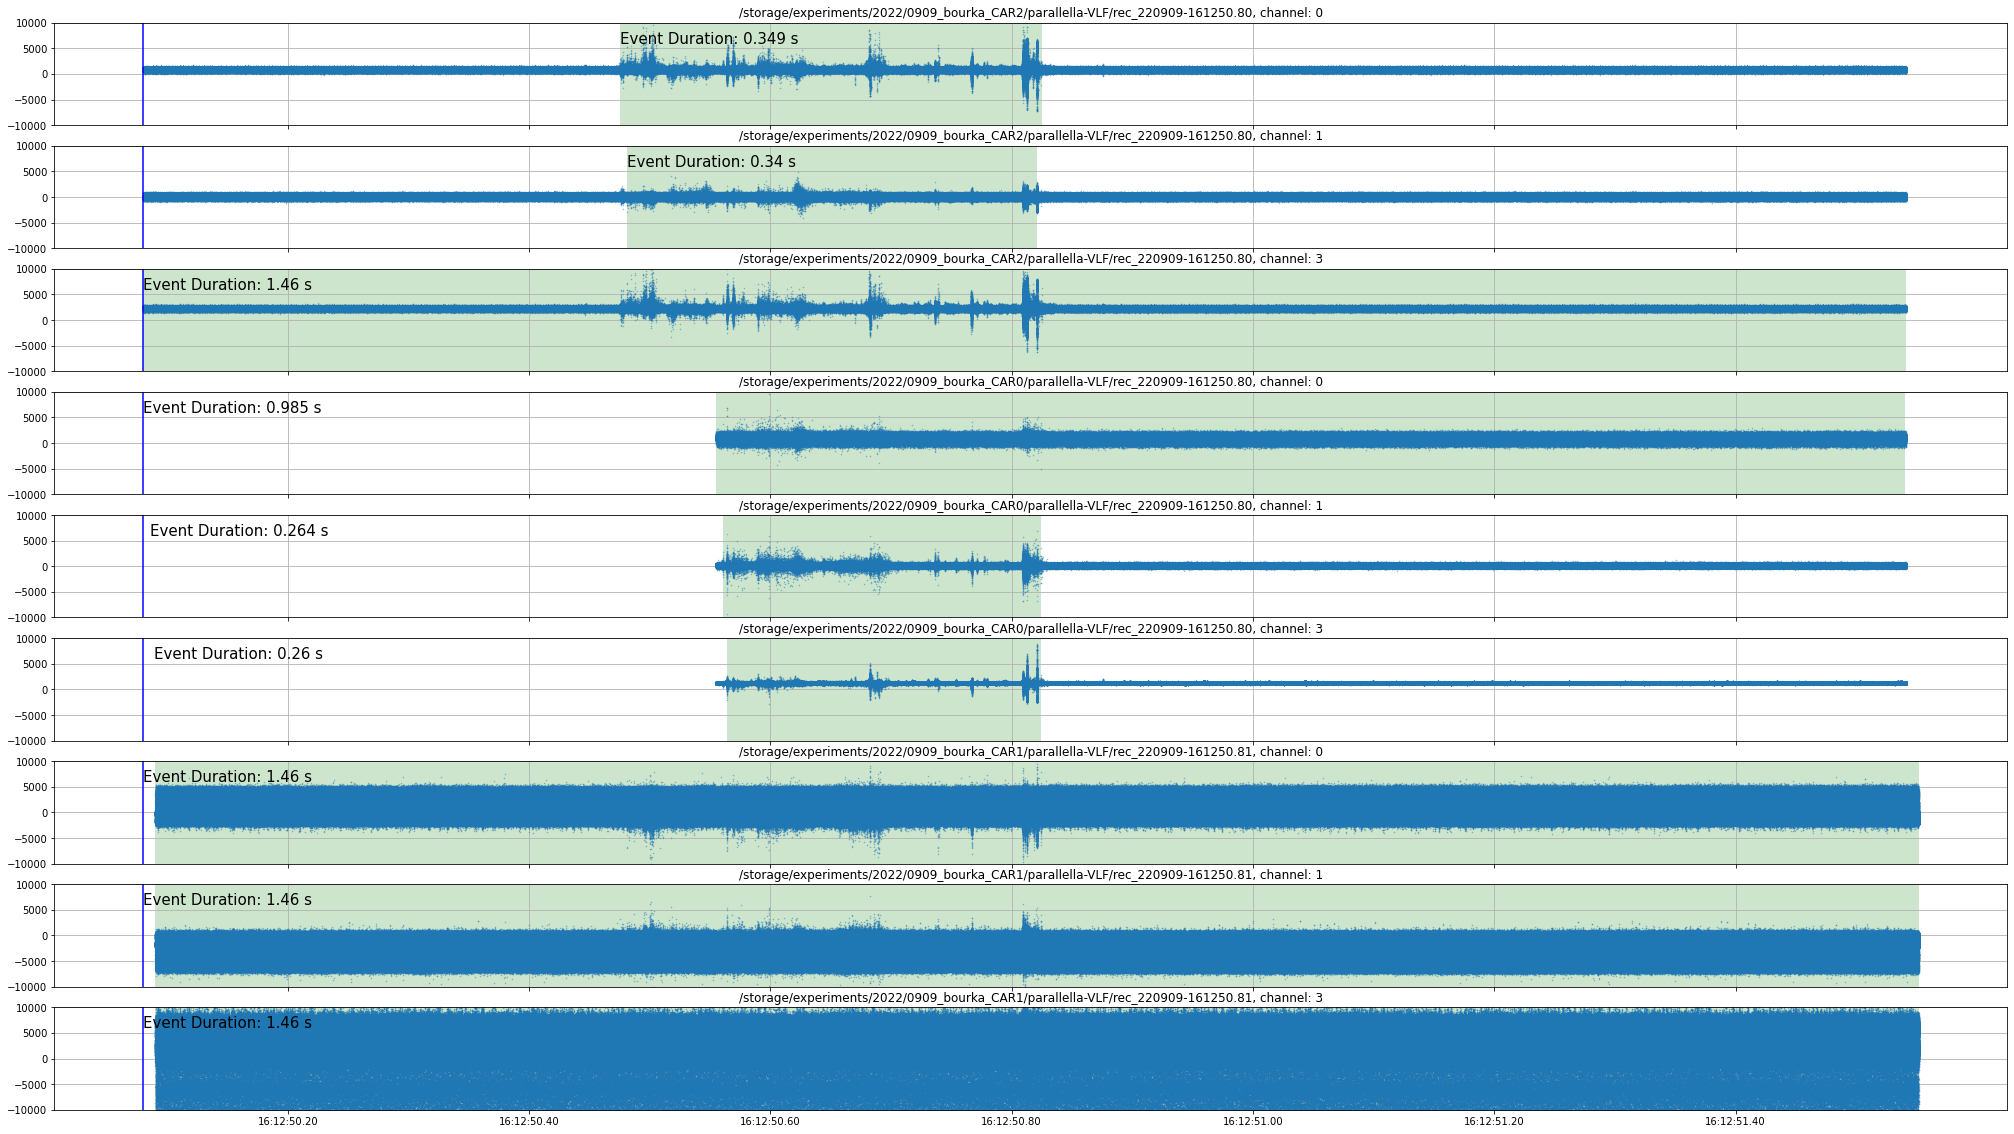

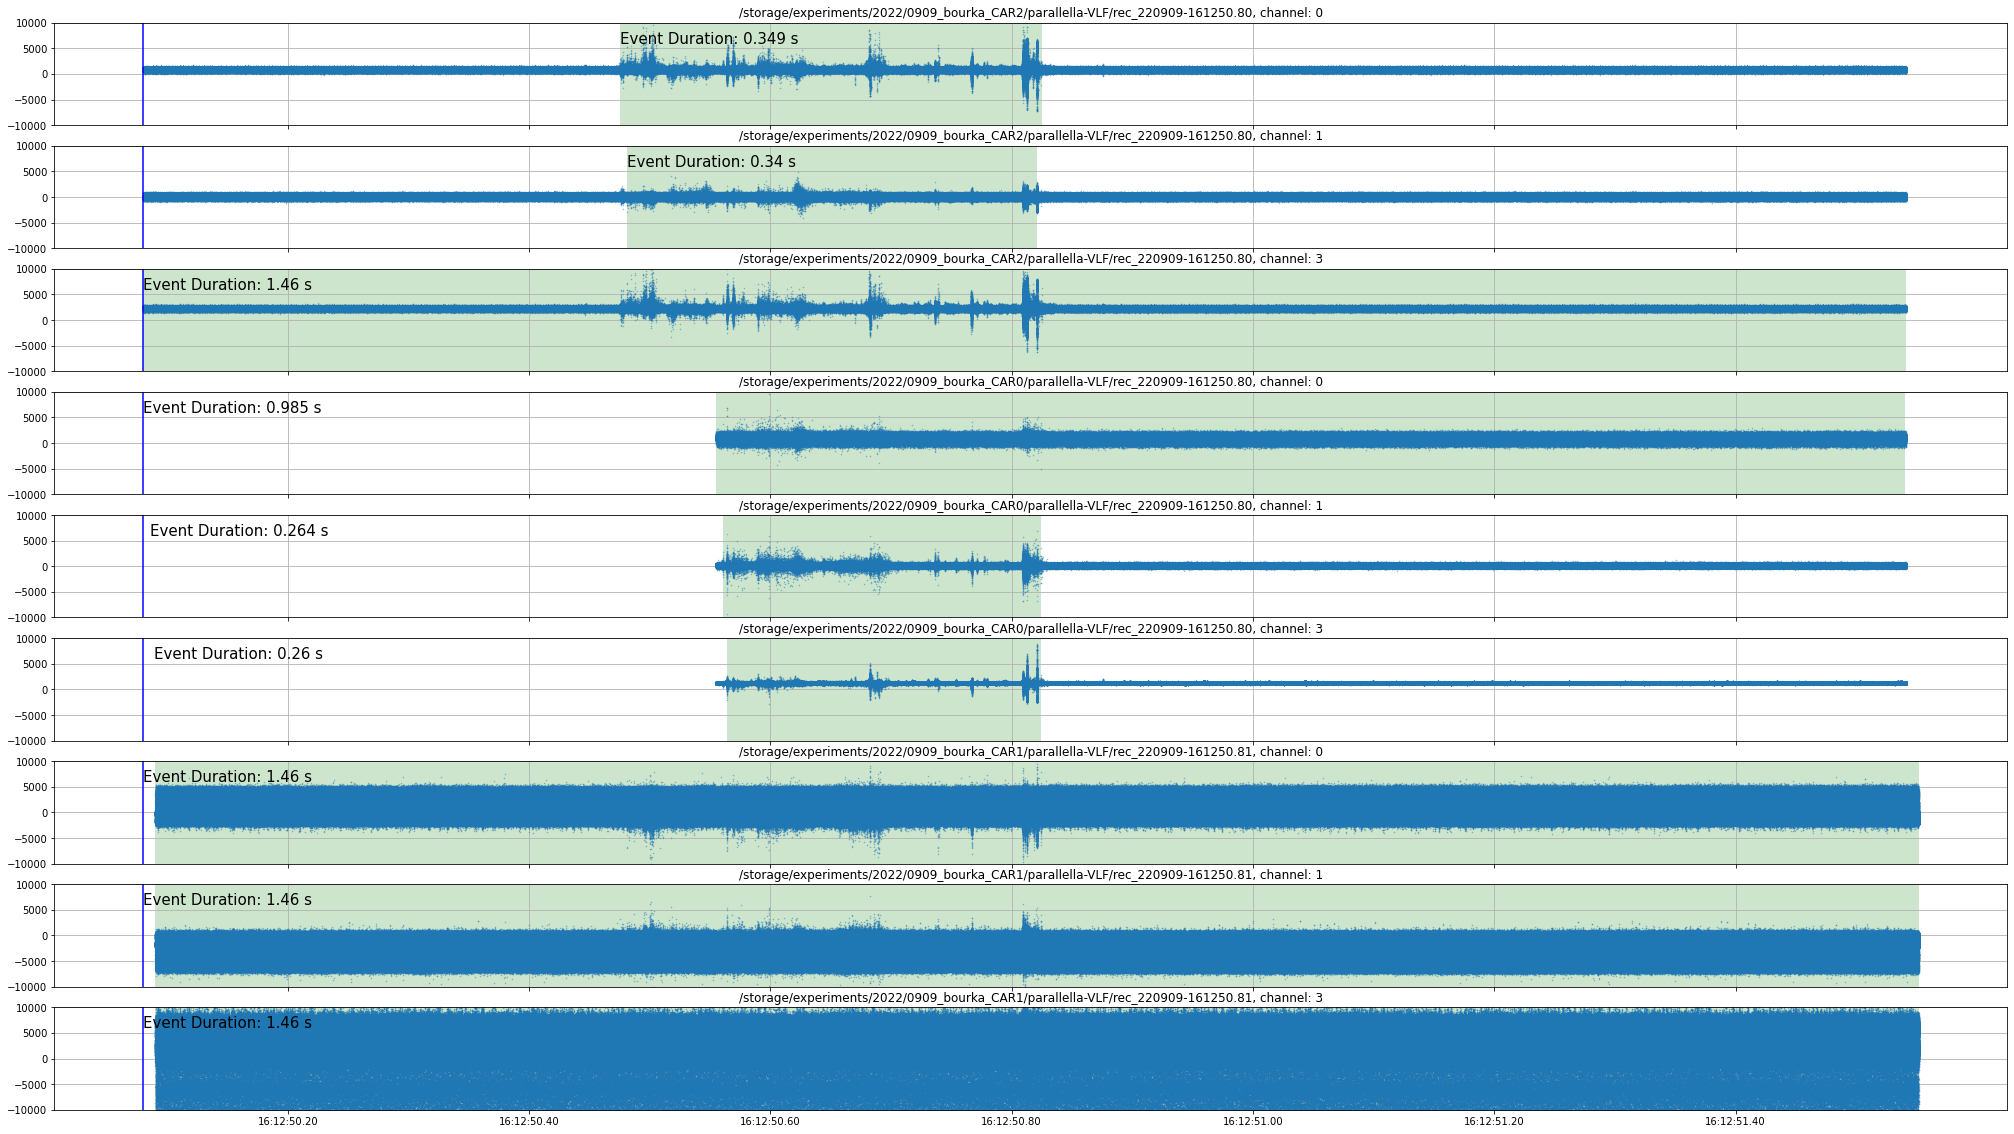

In [3]:
files = ['/storage/experiments/2022/0909_bourka_CAR2/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR0/parallella-VLF/rec_220909-161250.80',
         '/storage/experiments/2022/0909_bourka_CAR1/parallella-VLF/rec_220909-161250.81']
print(files)

multistation_plotrec(files)

Plot all lightning records (High memory and time consuming)

In [4]:
def extract_signal_fragment(files, date_str, start_time_str, end_time_str, selected_channels):
    fragments = []
    
    # Převod celého časového řetězce na objekty Timestamp
    start_datetime = pd.to_datetime(f'{date_str} {start_time_str}')
    end_datetime = pd.to_datetime(f'{date_str} {end_time_str}')

    for filepath in files:
        try:
            car_match = re.search(r'CAR(\d+)', filepath)
            if car_match:
                station_id = car_match.group(1)
            else:
                raise ValueError("Identifikátor stanice nebyl nalezen v cestě k souboru.")
            with open(filepath, 'rb') as file:
                fn = os.path.basename(filepath)
                h, samples, synclog = loadrec(file)
                t2s, s2t, _, _ = assign_time_axis(fn, h, synclog)

                # Získání indexů vzorků pro začátek a konec
                start_index = int(t2s(start_datetime))
                actual_start_index = max(start_index, 0)  # Korekce start_index, pokud je mimo rozsah
                end_index = min(int(t2s(end_datetime)), samples.shape[0])
                
                num_samples = end_index - start_index  # Počet vzorků v požadovaném okně
                
                if num_samples <= 0:
                    print(f"Časové okno '{start_datetime}' až '{end_datetime}' je mimo rozsah záznamu v souboru {filepath}.")
                    continue

                # Příprava fragmentu
                if start_index < 0:
                    padding_length = abs(start_index)
                    # Výpočet střední hodnoty pro padding se provádí jen pro skutečně načtená data
                    fragment = samples[0:end_index, :][:, selected_channels]
                else:
                    fragment = samples[actual_start_index:end_index, :][:, selected_channels]
                
                fragment_mean = np.mean(fragment, axis=0).astype(np.int16)
                
                # Doplňování středními hodnotami namísto nul
                if start_index < 0:
                    padding = np.full((padding_length, fragment.shape[1]), fragment_mean, dtype=np.int16)
                    fragment = np.vstack((padding, fragment))
                if fragment.shape[0] < num_samples:
                    padding_length = num_samples - fragment.shape[0]
                    padding = np.full((padding_length, fragment.shape[1]), fragment_mean, dtype=np.int16)
                    fragment = np.vstack((fragment, padding))
                
                fragments.append(('CAR'+station_id+'_'+fn, fragment))
                
        except Exception as e:
            print(f"Chyba při zpracování souboru {filepath}: {e}")
    
    return fragments


In [5]:
## Manually select a part of signal which corresponds to the lightning

date_str = "2022-09-09"
time_window_start = "16:12:50.45"  # Začátek extrakce
time_window_end = "16:12:50.85"    # Konec extrakce
selected_channels = [0, 1, 3] # [3]
output_directory = "./test_data/"


fragments = extract_signal_fragment(files, date_str, time_window_start, time_window_end, selected_channels)

for fn, fragment in fragments:
    # Uložení fragmentu do binárního souboru
    output_filename = f"{fn}_fragment.npy"
    output_path = os.path.join(output_directory, output_filename)
    np.save(output_path, fragment)
    print(f"Fragment uložen do {output_path}")
    print(f"Soubor: {fn}, Velikost fragmentu: {fragment.shape}, {fragment.dtype}")

Fragment uložen do ./test_data/CAR2_rec_220909-161250.80_fragment.npy
Soubor: CAR2_rec_220909-161250.80, Velikost fragmentu: (4000000, 3), int16
Fragment uložen do ./test_data/CAR0_rec_220909-161250.80_fragment.npy
Soubor: CAR0_rec_220909-161250.80, Velikost fragmentu: (4000000, 3), int16
Fragment uložen do ./test_data/CAR1_rec_220909-161250.81_fragment.npy
Soubor: CAR1_rec_220909-161250.81, Velikost fragmentu: (4000000, 3), int16


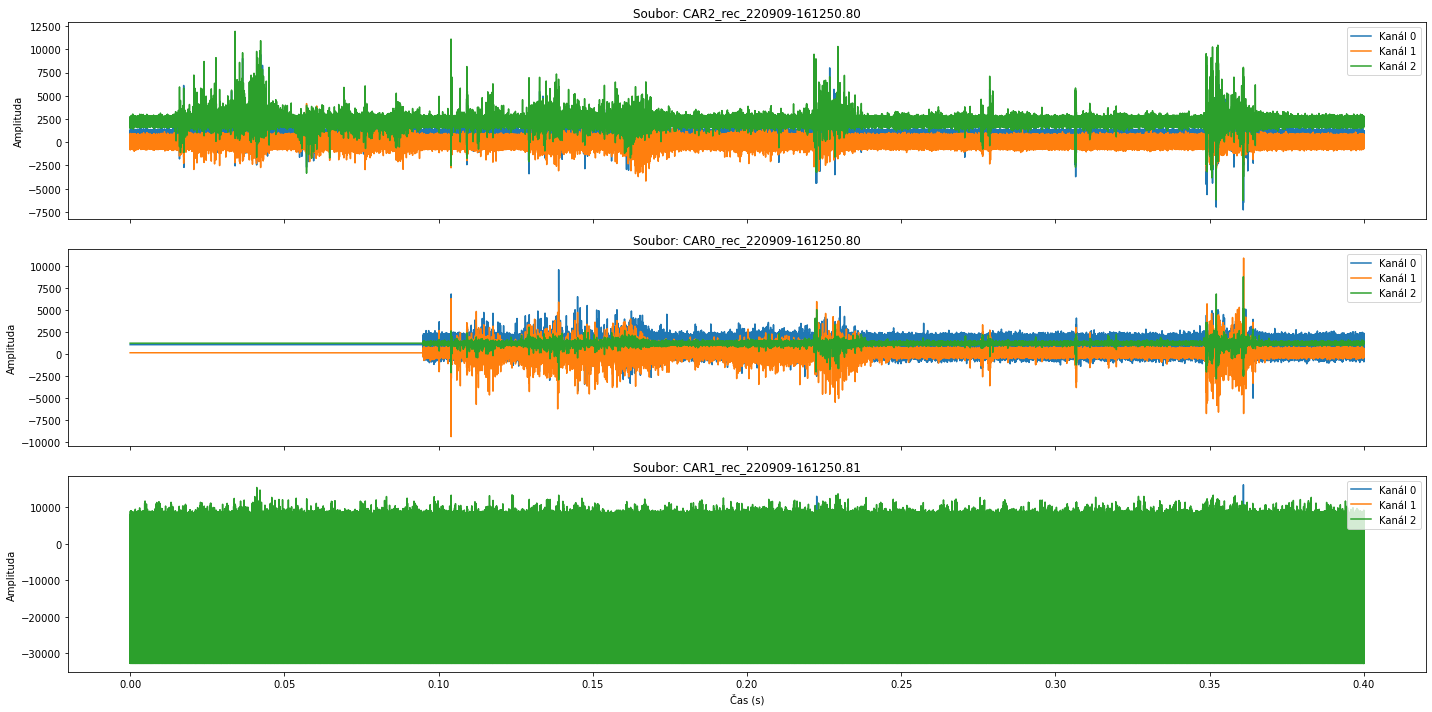

In [6]:
import matplotlib.pyplot as plt

def plot_fragments(fragments):
    num_fragments = len(fragments)
    fig, axs = plt.subplots(num_fragments, 1, figsize=(20, 10), sharex=True)

    if num_fragments == 1:  # Pokud je jen jeden fragment, axs není pole
        axs = [axs]

    for i, (filename, fragment) in enumerate(fragments):
        # Vytvoření časové osy (relativní, od 0)
        time_axis = np.linspace(0, fragment.shape[0]/sps, num=fragment.shape[0])

        # Vykreslení každého kanálu v fragmentu
        for ch in range(fragment.shape[1]):
            axs[i].plot(time_axis, fragment[:, ch], label=f'Kanál {ch}')
        
        axs[i].set_title(f'Soubor: {filename}')
        axs[i].set_ylabel('Amplituda')
        axs[i].legend(loc='upper right')

    axs[-1].set_xlabel('Čas (s)')
    plt.tight_layout()
    plt.show()

plot_fragments(fragments)


Normalizace signálů a jemné odstranění offsetu na úrovni float32

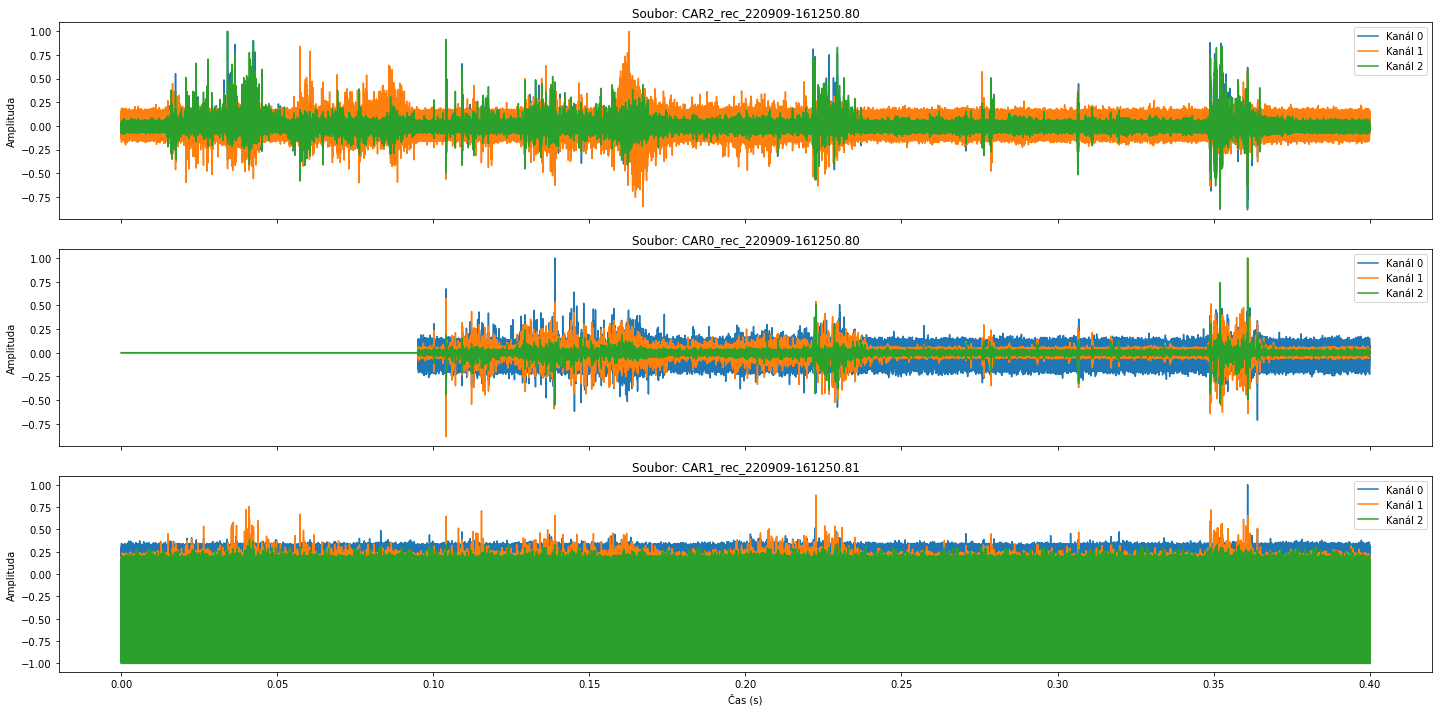

In [146]:
normalized_fragments = []

for fn, fragment in fragments:
    # Převedení na float pro zpracování
    fragment = fragment.astype(np.float32)
    
    # Odstranění DC offsetu pro každý kanál zvlášť
    fragment_mean = np.mean(fragment, axis=0)
    fragment -= fragment_mean[None, :]  # Použití broadcasting pro odčítání
    
    # Normalizace na rozsah -1 až 1 pro každý kanál zvlášť
    max_val = np.max(np.abs(fragment), axis=0)
    # Zabránění dělení nulou, nastavení nezměněných kanálů na nulu
    max_val[max_val == 0] = 1
    fragment /= max_val[None, :]  # Použití broadcasting pro dělení
    
    normalized_fragments.append((fn, fragment))


plot_fragments(normalized_fragments)

# Umístění měřících stanic

Zde jsou připraveny souřadnice a převedeny z formátu WGS84 do ECEF

In [8]:
import folium

# Define station positions
stations_geodetic = {
"CAR0": {"lat":50.469094667,"lon":13.765497667,"alt":372.600},
"CAR1": {"lat":50.523364667,"lon":13.543213167,"alt":244.200},
"CAR2": {"lat":50.393234833,"lon":13.693044500,"alt":210.300}
}

# Calculate the average latitude and longitude to center the map
avg_lat = sum(station["lat"] for station in stations_geodetic.values()) / len(stations_geodetic)
avg_lon = sum(station["lon"] for station in stations_geodetic.values()) / len(stations_geodetic)

# Create a map centered around the average location
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

# Add markers for each station
for name, pos in stations_geodetic.items():
    folium.Marker([pos["lat"], pos["lon"]], popup=name).add_to(m)

# Display the map in Jupyter Notebook
m


In [9]:
from pyproj import Proj, Transformer

# Initialize WGS84 (lat/lon) and ECEF coordinate systems
wgs84 = Proj(proj='latlong', datum='WGS84')
ecef = Proj(proj='geocent', datum='WGS84')

# Initialize a transformer to convert from WGS84 to ECEF
transformer = Transformer.from_proj(wgs84, ecef)

# Function to convert from geodetic to ECEF coordinates
def geodetic_to_ecef(lat, lon, alt):
    x, y, z = transformer.transform(lon, lat, alt, radians=False)
    return (x, y, z)

# Dictionary to store ECEF coordinates
stations_ecef = {}

# Convert station positions to ECEF and store in dictionary
for station, position in stations_geodetic.items():
    stations_ecef[station] = geodetic_to_ecef(position['lat'], position['lon'], position['alt'])

# Print ECEF coordinates
for station, ecef_coords in stations_ecef.items():
    print(f"{station} ECEF:", ecef_coords)


CAR0 ECEF: (3951150.9657826284, 967973.2862059791, 4896452.478554733)
CAR1 ECEF: (3950268.4794502985, 951527.1885485708, 4900193.852594219)
CAR2 ECEF: (3958591.6731348936, 964491.5289012508, 4890951.79087182)


In [148]:
from itertools import combinations
import numpy as np

# Mapování identifikátorů na stanice
id_to_station = {
    'CAR0_rec_220909-161250.80': 'CAR0',
    'CAR1_rec_220909-161250.81': 'CAR1',
    'CAR2_rec_220909-161250.80': 'CAR2'
}


# Výpočet vzdáleností mezi stanicemi
distances = {}

for (name1, pos1), (name2, pos2) in combinations(stations_ecef.items(), 2):
    # Výpočet vzdálenosti mezi stanicemi
    distance = np.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2 + (pos2[2] - pos1[2])**2)
    # Uložení výsledku
    distances[(name1, name2)] = distance

distances



{('CAR0', 'CAR1'): 16889.3691411816,
 ('CAR0', 'CAR2'): 9886.572956086962,
 ('CAR1', 'CAR2'): 17965.672232678593}

# Korelace signálů mezi stanicemi

V tomto kroku jsou vypočteny TDOA z extrahovaných fragmentů signálů

TDOA mezi CAR2_rec_220909-161250.80 a CAR1_rec_220909-161250.81 překračuje fyzickou vzdálenost, hledání alternativy...
TDOA mezi CAR0_rec_220909-161250.80 a CAR1_rec_220909-161250.81 překračuje fyzickou vzdálenost, hledání alternativy...
TDOA mezi CAR0_rec_220909-161250.80 a CAR1_rec_220909-161250.81 překračuje fyzickou vzdálenost, hledání alternativy...


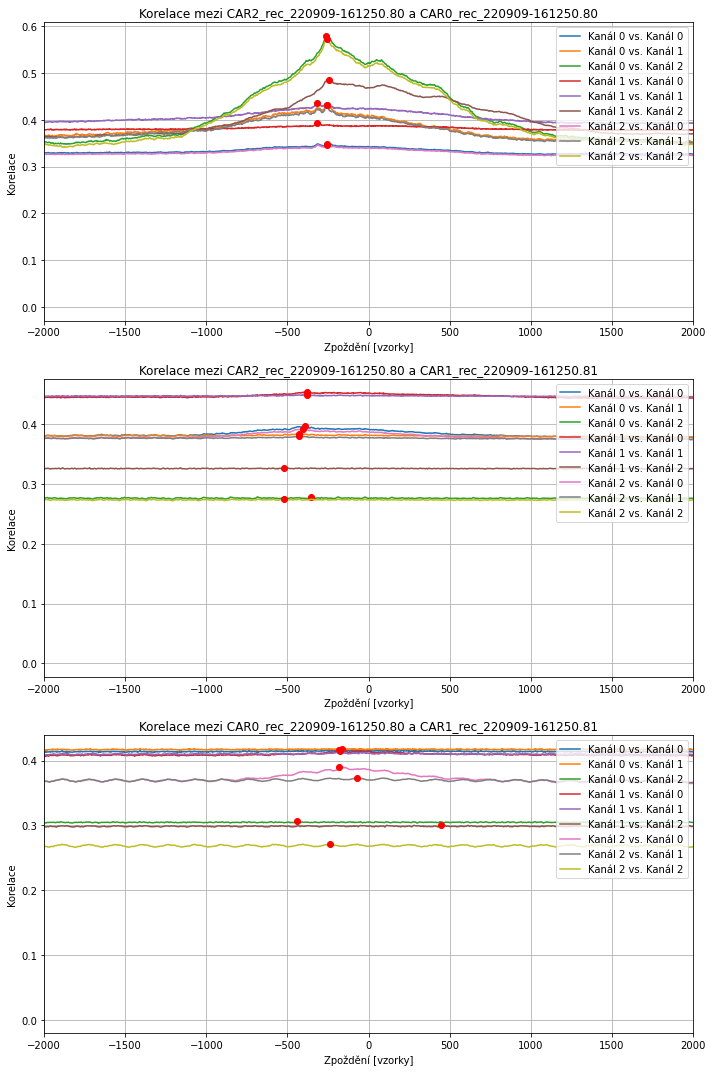

Zpoždění mezi CAR2_rec_220909-161250.80 a CAR0_rec_220909-161250.80:
                Kanál  1           Kanál  2           Kanál  3
            [µs]      [m]     [µs]      [m]     [µs]      [m] 
Kanál  1    -25.3    -7590     -25.6    -7680     -26.3    -7890  
Kanál  2    -31.5    -9450     -31.7    -9510     -24.6    -7380  
Kanál  3    -25.4    -7620     -25.8    -7740     -25.9    -7770  


Zpoždění mezi CAR2_rec_220909-161250.80 a CAR1_rec_220909-161250.81:
                Kanál  1           Kanál  2           Kanál  3
            [µs]      [m]     [µs]      [m]     [µs]      [m] 
Kanál  1    -39.0   -11700     -42.8   -12840     -35.4   -10620  
Kanál  2    -38.1   -11430     -38.1   -11430     -52.1   -15630  
Kanál  3    -40.3   -12090     -42.8   -12840     -51.9   -15570  


Zpoždění mezi CAR0_rec_220909-161250.80 a CAR1_rec_220909-161250.81:
                Kanál  1           Kanál  2           Kanál  3
            [µs]      [m]     [µs]      [m]     [µs]      [m] 
Kanál  1 

In [150]:
from itertools import combinations, product
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Příprava dat z normalized_fragments pro snazší manipulaci
data = {name: np.abs(fragment) for name, fragment in normalized_fragments}

# Nastavení figure pro vykreslení grafů
fig, axs = plt.subplots(nrows=len(data)*(len(data)-1)//2, ncols=1, figsize=(10, 15))
if len(data)*(len(data)-1)//2 == 1:
    axs = [axs]  # Abychom mohli iterovat i když je jen jeden graf
axs_idx = 0

# Uložení výsledků zpoždění pro výpis
tdoa_results = {}

max_time_delays = {k: v / c for k, v in distances.items()}

for (name1, fragment1), (name2, fragment2) in combinations(data.items(), 2):
    # Převedení identifikátorů záznamů na jména stanic
    station1 = id_to_station[name1]
    station2 = id_to_station[name2]

    # Kontrola, aby klíče byly ve správném pořadí (podle abecedy, pro konzistentnost)
    station_pair = tuple(sorted([station1, station2]))

    # Maximální dovolené zpoždění mezi těmito stanicemi v časových jednotkách (s)
    max_delay_time = max_time_delays[station_pair]
    # Převod na vzorky
    max_delay_samples = int(max_delay_time * sps)
        
    delay_matrix = np.zeros((fragment1.shape[1], fragment2.shape[1]))
    for channel1, channel2 in product(range(fragment1.shape[1]), range(fragment2.shape[1])):
        signal1, signal2 = fragment1[:, channel1], fragment2[:, channel2]
        corr = correlate(signal1, signal2, mode='full', method='auto')
        corr /= np.sqrt(np.dot(signal1, signal1) * np.dot(signal2, signal2))
        lags = np.arange(-len(signal1)+1, len(signal2))

        # Získání indexu a hodnoty maximální korelace
        max_corr_index = np.argmax(corr)
        max_corr_value = corr[max_corr_index]
        max_lag = lags[max_corr_index]

        # Kontrola, zda maximální zpoždění nepřekračuje fyzikální omezení
        if abs(max_lag) > max_delay_samples:
            print(f"TDOA mezi {name1} a {name2} překračuje fyzickou vzdálenost, hledání alternativy...")
            # Možnost vyhledání dalšího nejvyššího vrcholu, který splňuje podmínku
            # Toto je jednoduchý příklad, který vezme první menší vrchol; můžete chtít sofistikovanější metodu
            valid_corr_indices = np.where(abs(lags) <= max_delay_samples)[0]
            max_corr_index = valid_corr_indices[np.argmax(corr[valid_corr_indices])]
            max_lag = lags[max_corr_index]

        delay_matrix[channel1, channel2] = max_lag / sps

        # Vykreslení korelace pro tuto kombinaci
        axs[axs_idx].plot(lags, corr, label=f'Kanál {channel1} vs. Kanál {channel2}')
        axs[axs_idx].plot(max_lag, corr[max_corr_index], 'ro')  # Zvýraznění nového maxima

    axs[axs_idx].set_title(f'Korelace mezi {name1} a {name2}')
    axs[axs_idx].set_xlabel('Zpoždění [vzorky]')
    axs[axs_idx].set_xlim(-2e3, 2e3)  # Případné úpravy pro lepší vizualizaci
    axs[axs_idx].set_ylabel('Korelace')
    axs[axs_idx].legend(loc="upper right")
    axs[axs_idx].grid(True)
    
    axs_idx += 1
    tdoa_results[(name1, name2)] = delay_matrix

plt.tight_layout()
plt.show()

for (station_pair, delay_matrix) in tdoa_results.items():
    print(f"Zpoždění mezi {station_pair[0]} a {station_pair[1]}:")
    header_channels = "               " + "          ".join([f" Kanál {i+1:2}" for i in range(delay_matrix.shape[1])])
    header_units = "        " + "    [µs]      [m] " * delay_matrix.shape[1]
    print(header_channels)
    print(header_units)
    
    # Výpis hodnot zpoždění v mikrosekundách a v metrech s lepším formátováním
    for i, row in enumerate(delay_matrix):
        row_str = f"Kanál {i+1:2} " + "".join([f"{delay*1e6:8.1f} {delay*c:8.0f}  " for delay in row])
        print(row_str)
    print("\n")  # Oddělení tabulek pro lepší čitelnost


In [144]:
type(tdoa_results['CAR2_rec_220909-161250.80',
  'CAR1_rec_220909-161250.81'])


numpy.ndarray

In [110]:
import numpy as np
from scipy.optimize import minimize

# ECEF souřadnice stanic (příklad)
CAR0_ecef = np.array([3951150.9657826284, 967973.2862059791, 4896452.478554733])
CAR1_ecef = np.array([3950268.4794502985, 951527.1885485708, 4900193.852594219])
CAR2_ecef = np.array([3958591.6731348936, 964491.5289012508, 4890951.79087182])

# TDOA hodnoty (s)
TDOA_CAR2_CAR0 = tdoa_results['CAR2_rec_220909-161250.80','CAR0_rec_220909-161250.80'][0][2]
TDOA_CAR2_CAR1 = tdoa_results['CAR2_rec_220909-161250.80','CAR1_rec_220909-161250.81'][2][2]
TDOA_CAR0_CAR1 = tdoa_results['CAR0_rec_220909-161250.80','CAR1_rec_220909-161250.81'][2][2]

def calculate_distances(strike_position, sensors):
    """Calculate the distance from the strike position to each sensor."""
    return np.linalg.norm(sensors - strike_position, axis=1)

def calculate_tdoa(distances):
    """Calculate TDOA values. The third TDOA is theoretically not independent, but in practice there is noise"""
    # return (distances - distances[1]) / c
    return np.array([distances[2] - distances[0], 
                     distances[2] - distances[1], 
                     distances[0] - distances[1]]) / c

# Pozice stanic jako matice
station_positions = np.array([CAR0_ecef, CAR1_ecef, CAR2_ecef])

# TDOA hodnoty jako pole (předpokládáme, že TDOA jsou měřeny ve stejném pořadí jako rozdíly pozic)
tdoas_corrected = np.array([TDOA_CAR2_CAR0, TDOA_CAR2_CAR1, TDOA_CAR0_CAR1])

def estimate_strike_position(sensors, tdoas):
    """
    Estimate the lightning strike position using the TDOA measurements with constraints.
    """
    def func_to_minimize(strike):
        estimated_distances = calculate_distances(strike, sensors)
        estimated_tdoas = calculate_tdoa(estimated_distances)
        return np.sum((estimated_tdoas*1e6 - tdoas*1e6)**2)
    
    # Počáteční odhad polohy blesku
    initial_guess = np.mean(sensors, axis=0)
    # Definice omezení - vzdálenost výboje maximálně 100km od kterékoli stanice
    constraints = ({'type': 'ineq', 
                    'fun': lambda strike: 100000 - np.linalg.norm(sensors[0] - strike)},  # Omezení pro první stanici
                   {'type': 'ineq', 
                    'fun': lambda strike: 100000 - np.linalg.norm(sensors[1] - strike)},  # Omezení pro druhou stanici
                   {'type': 'ineq', 
                    'fun': lambda strike: 100000 - np.linalg.norm(sensors[2] - strike)})  # Omezení pro třetí stanici

    # Zavedení tolerance pro konvergenci
    options = {'ftol': 1e-17, 'disp': False}  # Nastavuje toleranci změny funkce a povoluje zobrazení výstupu
    
    # Optimalizační proces s omezeními
    result = minimize(func_to_minimize, initial_guess, method='SLSQP', constraints=constraints, options=options)
    
    if result.success:
        return result.x
    else:
        return None  # Vrátí None, pokud optimalizace selže
    
# Estimate the lightning strike position
estimated_position_ecef = estimate_strike_position(station_positions, tdoas_corrected)

print(estimated_position_ecef)

#distances
estimated_distances = np.sqrt(np.sum((station_positions - estimated_position_ecef)**2, axis=1))
estimated_tdoas = np.array([estimated_distances[2] - estimated_distances[0], 
                            estimated_distances[2] - estimated_distances[1], 
                            estimated_distances[0] - estimated_distances[1]]) / c
print("Estimated position error")
print(np.sum((estimated_tdoas-tdoas_corrected)**2))


[3957924.21435916  963642.21028477 4891658.09409008]
Estimated position error
1.0800000000638945e-12


In [97]:
successful_positions[1]

array([3953337.03945594,  961330.66788527, 4895866.04067359])

In [98]:
transformer.transform(*estimated_position_ecef[:2], estimated_position_ecef[2])

(13.6836604148962, 50.40316605813533, 212.99954318907112)

In [100]:
### from pyproj import Transformer
import folium

# Inicializace transformátoru pro převod z ECEF do WGS84
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

# Převod ECEF souřadnic na geodetické souřadnice (lat, lon)
estimated_position_latlon = transformer.transform(*estimated_position_ecef[:2], estimated_position_ecef[2])

# Vytvoření mapy s odhadovanou pozicí blesku
m = folium.Map(location=[estimated_position_latlon[1], estimated_position_latlon[0]], zoom_start=8)
folium.Marker([estimated_position_latlon[1], estimated_position_latlon[0]], popup='Odhadovaná pozice blesku').add_to(m)

# Zobrazení mapy
m


In [138]:
import numpy as np
from itertools import product

def expand_stations_and_tdoas(stations_ecef, tdoa_results, id_to_station):
    successful_estimates_with_tdoa = []  # Seznam pro ukládání úspěšných odhadů s TDOA
    tdoa_used = set()  # Množina pro uchování již použitých TDOA kombinací jako tuple

    for tdoa_combination in product(*[tdoa_results[key] for key in tdoa_results]):
        for permutation in product(*tdoa_combination):
            tdoa_values = np.array(permutation).flatten()  # Udržení jako numpy array pro další zpracování

            # Kontrola, zda byla kombinace TDOA již použita (převod na tuple pro hashovatelnost)
            tdoa_tuple = tuple(tdoa_values)
            if tdoa_tuple in tdoa_used:
                continue  # Pokud ano, přeskočit tuto kombinaci
            
            # Přidání kombinace do množiny použitých TDOA
            tdoa_used.add(tdoa_tuple)

            sensors = np.array([stations_ecef[station] for station in id_to_station.values()])
            estimated_position = estimate_strike_position(sensors, tdoa_values)
            
            if estimated_position is not None:
                # Uložení dvojice (odhadovaná pozice, TDOA hodnoty) do seznamu
                successful_estimates_with_tdoa.append((estimated_position, tdoa_values))
            else:
                print("Optimalizace selhala pro kombinaci TDOA:", tdoa_values)

    return successful_estimates_with_tdoa

# Spuštění procesu s aktuálními daty a uložení výsledků
successful_positions = expand_stations_and_tdoas(stations_ecef, tdoa_results, id_to_station)

Optimalizace selhala pro kombinaci TDOA: [-2.63e-05 -3.81e-05  4.48e-05]


In [139]:
len(successful_positions)

566

In [154]:
from pyproj import Transformer
import folium

# Inicializace transformátoru pro převod z ECEF do WGS84
transformer = Transformer.from_crs("epsg:4978", "epsg:4326", always_xy=True)

# Vytvoření prázdné mapy
m = folium.Map(location=[0, 0], zoom_start=9)  # Upravte pro vhodné počáteční umístění a přiblížení

# Iterace přes všechny úspěšné odhady pozic a příslušné TDOA hodnoty
for position_with_tdoa in successful_positions:
    position, tdoa_values = position_with_tdoa
    # Převod ECEF souřadnic na geodetické souřadnice (lat, lon)
    lat, lon, _ = transformer.transform(*position[:2], position[2])
    
    # Vytvoření pop-up textu zahrnujícího TDOA hodnoty
    popup_text = f"Odhadovaná pozice blesku\nTDOA: {tdoa_values}"
    
    # Přidání markeru pro každou odhadovanou pozici s menší značkou a pop-up informacemi
    folium.CircleMarker(
        [lon, lat ],
        radius=5,  # Menší velikost značky
        popup=popup_text,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

    
# Převod a přidání každé stanice jako marker na mapu
for station_name, ecef_coords in stations_ecef.items():
    latlon = transformer.transform(ecef_coords[0], ecef_coords[1], ecef_coords[2])
    folium.Marker([latlon[1], latlon[0]], popup=station_name).add_to(m)
    
# Nastavení centra mapy na první odhadovanou pozici (pouze pro lepší vizualizaci)
if successful_positions:
    first_position, _ = successful_positions[0]
    first_lat, first_lon, _ = transformer.transform(*first_position[:2], first_position[2])
    m.location = [first_lon, first_lat]

# Zobrazení mapy
m



# Test of numerical approach

Calculate position of randomly generated lightning TDOAs data


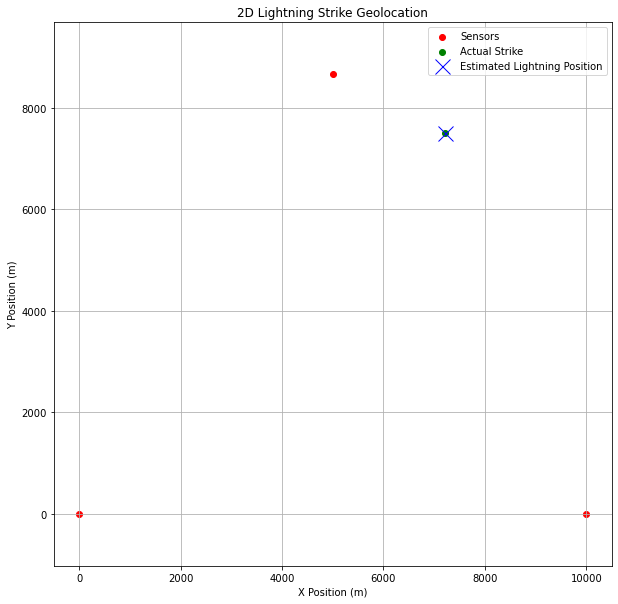

Actual Strike Position: [7209.03711959 7506.80476278]
Estimated Strike Position: [7209.03712254 7506.80478799]


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Constants
c = 3e8  # Speed of light in m/s

# Helper functions
def generate_random_strike(area_size=(10000, 10000)):
    """Generate a random lightning strike location within the given area."""
    return np.random.rand(2) * area_size

def calculate_distances(strike_position, sensors):
    """Calculate the distance from the strike position to each sensor."""
    return np.linalg.norm(sensors - strike_position, axis=1)

def calculate_tdoa(distances):
    """Calculate TDOA values. The third TDOA is theoretically not independent, but in practice there is noise"""
    # return (distances - distances[1]) / c
    return np.array([distances[2] - distances[0], 
                     distances[2] - distances[1], 
                     distances[0] - distances[1]]) / c

def estimate_strike_position(sensors, tdoas):
    """
    Estimate the lightning strike position using the TDOA measurements.
    """
    # Optimization function to minimize
    def func_to_minimize(strike):
        estimated_distances = calculate_distances(strike, sensors)
        estimated_tdoas = calculate_tdoa(estimated_distances)
        # Minimize the difference between the actual TDOA and the estimated TDOA
        return np.sum((estimated_tdoas - tdoas )**2)

    # Initial guess (we use the geometry center of the sensor positions)
    initial_guess = np.mean(sensors, axis=0)
    
    # Minimize the optimization function
    result = minimize(func_to_minimize, initial_guess, method='Nelder-Mead')
    
    # Return the estimated position of the lightning strike
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed")

# Place three sensors
sensors = np.array([[0, 0], [10000, 0], [5000, 8660]])  # Equilateral triangle layout

# Generate a random lightning strike
strike_position = generate_random_strike()

# Calculate actual distances and TDOAs
distances = calculate_distances(strike_position, sensors)
tdoas = calculate_tdoa(distances)

# Estimate the lightning strike position
estimated_strike = estimate_strike_position(sensors, tdoas)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(sensors[:, 0], sensors[:, 1], c='red', label='Sensors')
plt.scatter(strike_position[0], strike_position[1], c='green', label='Actual Strike')
plt.plot(*estimated_strike, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.title('2D Lightning Strike Geolocation')
plt.grid(True)
plt.axis('equal')
plt.show()

# Print actual and estimated positions
print("Actual Strike Position:", strike_position)
print("Estimated Strike Position:", estimated_strike)


# Automatické získání pozice auta

Pokusy s automatickou extrakcí pozice aut ze záznamu

In [ ]:
# Tohle by mělo extrahovat souřadnice z GPS záznamů blízko  zvolenému časovému úseku, ale nefunguje to. 
from datetime import datetime, timedelta

def find_closest_coordinates(log_file_path, time_window_start, time_window_end):
    tw_start = datetime.strptime(time_window_start, "%H:%M:%S.%f").time()
    tw_end = datetime.strptime(time_window_end, "%H:%M:%S.%f").time()

    closest_time = None
    closest_coords = None
    closest_time_diff = timedelta.max

    with open(log_file_path, 'r', errors='ignore') as file:
        for line in file:
            try:
                if line.startswith('$GNGGA') or line.startswith('$GPGGA'):
                    msg = pynmea2.parse(line)
                    msg_time = msg.timestamp  # předpokládáme, že je to objekt datetime.time bez informací o časové zóně
                    if msg_time:
                        if tw_start <= msg_time <= tw_end:
                            current_datetime = datetime.combine(datetime.min, msg_time)
                            start_datetime = datetime.combine(datetime.min, tw_start)
                            end_datetime = datetime.combine(datetime.min, tw_end)
                            time_diff_start = abs(current_datetime - start_datetime)
                            time_diff_end = abs(current_datetime - end_datetime)
                            min_time_diff = min(time_diff_start, time_diff_end)

                            if min_time_diff < closest_time_diff:
                                closest_time = msg_time
                                closest_coords = (msg.latitude, msg.longitude)
                                closest_time_diff = min_time_diff
            except pynmea2.ParseError:
                # Ignorování chyb při parsování
                continue

    if closest_time:
        return closest_time, closest_coords, closest_time_diff.total_seconds()
    else:
        return None, None, None



In [ ]:
log_file_path = '/storage/experiments/2022/0909_bourka_CAR2/gps/base_gps_CAR2_20220909_105954.log'

time_window_start = "16:12:50.45"  # Začátek extrakce
time_window_end = "16:12:50.85"    # Konec extrakce

closest_time, closest_coords, time_diff = find_closest_coordinates(log_file_path, time_window_start, time_window_end)

if closest_time:
    print(f"Nearest coordinates to time window: {closest_coords} at {closest_time.strftime('%H:%M:%S.%f')}, time difference: {time_diff}")
else:
    print("No coordinates found within the time window.")



# Algebraic approach Quadratic Planar (QP) method
Snaha o implementaci [Quadratic Planar (QP) method](https://journals.ametsoc.org/view/journals/atot/17/3/1520-0426_2000_017_0279_drafvt_2_0_co_2.xml) na rozdíl od numerického přístupu to momentálně moc nefunguje

In [ ]:
def accurate_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Accurate estimation of the lightning position using the QP method.
    This function uses a more precise approach than the simplified version.
    """
    # The sensor positions are assumed to be in a planar coordinate system with the first sensor at the origin.
    # The reference sensor for TDOA is the first sensor.
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    
    # Compute q' values based on the equation q' = (1/2) * (r_i^2 - c^2 * t_i^2) for i = 2, 3
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * tdoa[1]**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * tdoa[2]**2)
    
    # Calculate the coefficients A, B, and C for the quadratic equation in r
    A = c**2 * (tdoa[2]**2 - tdoa[1]**2) - (x3 - x2)**2 - (y3 - y2)**2
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    # Solve the quadratic equation to find r
    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    # Choose the positive root which has the smallest absolute value as the solution
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        return None  # No valid r found
    
    # With r calculated, we can solve the linear system to find the estimated position (x, y)
    # The linear system is given by: q = Qr where Q is the matrix composed of the sensor positions (excluding the first one),
    # and q is the vector of q' values for the corresponding sensors.
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    # Solving the linear system Qr = q for r (position vector [x, y])
    position_vector = np.linalg.solve(Q, q)
    
    # Add the position of the first sensor to get absolute position
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

# Perform the TDOA calculation and estimation again
tdoa = calculate_tdoa(lightning_position, sensor_positions)
estimated_position = accurate_qp_method(sensor_positions, tdoa)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Lightning Position Estimation with Accurate QP Method')
plt.grid(True)
plt.show()

# Let's also return the positions for reference
(lightning_position, estimated_position)


In [ ]:
# Redefine the accurate_qp_method_debug function to include 'c' within the scope for plotting
def accurate_qp_method_debug(sensor_positions, tdoa):
    """
    Accurate estimation of the lightning position using the QP method.
    This function uses a more precise approach than the simplified version.
    Added debug information to identify issues with the estimation.
    """
    c = 3e8  # Speed of light in m/s
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    t2, t3 = tdoa[1], tdoa[2]
    
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * t2**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * t3**2)
    
    A = c**2 * (t3**2 - 2*t2*t3 + t2**2) - ((x3 - x2)**2 + (y3 - y2)**2)
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    discriminant = B**2 - 4*A*C
    print(f"Discriminant: {discriminant}, A: {A}, B: {B}, C: {C}")

    if discriminant < 0:
        print("No real solution. Complex roots encountered.")
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        print("No valid r found.")
        return None
    
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    position_vector = np.linalg.solve(Q, q)
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

# Perform the TDOA calculation and estimation again with debug information
estimated_position = accurate_qp_method_debug(sensor_positions, tdoa)

# Plotting TDOA circles and fixing the previous scope error
plt.figure(figsize=(10, 8))
c = 3e8  # Speed of light in m/s, for plotting purposes
for i, sensor in enumerate(sensor_positions):
    circle = plt.Circle(sensor, tdoa[i]*c, color='blue', fill=False, linestyle='dotted')
    plt.gca().add_artist(circle)
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('TDOA Circles and Lightning Position Estimation with Debugging')
plt.grid(True)
plt.axis('equal')
plt.show()

# Print out the estimated position or None
estimated_position



In [ ]:
def revised_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Revised version of the QP method.
    Corrects the calculation of the coefficients and discriminant.
    """
    # Define positions relative to the first sensor
    rel_positions = sensor_positions - sensor_positions[0]
    x2, y2 = rel_positions[1]
    x3, y3 = rel_positions[2]
    
    # Calculate q' values based on the relative positions and TDOA
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * tdoa[1]**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * tdoa[2]**2)
    
    # Coefficients for the quadratic equation
    A = (x3 - x2)**2 + (y3 - y2)**2 - c**2 * (tdoa[2] - tdoa[1])**2
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    # Discriminant
    discriminant = B**2 - 4*A*C
    # Return detailed information if discriminant is negative
    if discriminant < 0:
        return None, {
            "A": A,
            "B": B,
            "C": C,
            "discriminant": discriminant,
            "message": "Complex roots, no real solution"
        }
    
    # Roots
    sqrt_discriminant = np.sqrt(discriminant)
    r1 = (-B + sqrt_discriminant) / (2*A)
    r2 = (-B - sqrt_discriminant) / (2*A)
    
    # Choose the smallest non-negative root as the correct solution
    r = min(filter(lambda r: r >= 0, [r1, r2]), default=None)
    # Return None if no non-negative root is found
    if r is None:
        return None, {
            "A": A,
            "B": B,
            "C": C,
            "discriminant": discriminant,
            "roots": (r1, r2),
            "message": "No valid non-negative root found"
        }
    
    # Since we know r, we can solve the linear system for (x, y)
    # The equations are: x2*x + y2*y = q2_prime and x3*x + y3*y = q3_prime
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    # Solve the linear system to find the estimated position
    estimated_position = np.linalg.solve(Q, q)
    
    return estimated_position, {
        "A": A,
        "B": B,
        "C": C,
        "discriminant": discriminant,
        "roots": (r1, r2),
        "chosen_root": r,
        "estimated_position": estimated_position
    }

# Rerun the estimation with the revised method
estimated_position, debug_info = revised_qp_method(sensor_positions, tdoa)

# Plotting for visualization
plt.figure(figsize=(10, 8))
plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
plt.legend()
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Lightning Position Estimation with Revised QP Method')
plt.grid(True)
plt.show()

# Return the estimated position and debug info
(estimated_position, debug_info)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lightning_location(area_size=(1000, 1000)):
    """Generate a random lightning strike location."""
    x = np.random.uniform(0, area_size[0])
    y = np.random.uniform(0, area_size[1])
    return np.array([x, y])

def calculate_tdoa(lightning_position, sensor_positions, c=3e8):
    """Calculate Time-Difference-of-Arrival for each sensor."""
    distances = np.linalg.norm(sensor_positions - lightning_position, axis=1)
    times = distances / c
    tdoa = times - times[0]  # Reference to the first sensor
    return tdoa

def generate_hyperbola(sensor1, sensor2, tdoa, c=3e8):
    """
    Generate points on a hyperbola corresponding to the TDOA between two sensors.
    """
    # Calculate the foci distance of the hyperbola (2a)
    d = np.linalg.norm(sensor1 - sensor2)
    
    # Calculate the difference in distances from the foci to any point on the hyperbola (2c)
    # c > a for a hyperbola, here c is the TDOA times the speed of light
    diff_distance = c * tdoa  # This is 2c in the hyperbola equation
    
    # Calculate semi-minor axis (b) using hyperbola equation c^2 = a^2 + b^2
    a = d / 2
    b = np.sqrt((diff_distance / 2)**2 - a**2)
    
    # Generate points on the hyperbola
    theta = np.linspace(-np.pi/2, np.pi/2, 1000)
    x = a * np.cosh(theta)
    y = b * np.sinh(theta)
    
    # Rotation matrix to align the hyperbola with the sensors
    delta_x = sensor2[0] - sensor1[0]
    delta_y = sensor2[1] - sensor1[1]
    angle = np.arctan2(delta_y, delta_x)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    
    # Rotate and translate hyperbola points
    points = np.dot(rotation_matrix, np.vstack([x, y]))
    points[0, :] += (sensor1[0] + sensor2[0]) / 2
    points[1, :] += (sensor1[1] + sensor2[1]) / 2
    
    return points

def accurate_qp_method(sensor_positions, tdoa, c=3e8):
    """
    Accurate estimation of the lightning position using the QP method.
    """
    x2, y2 = sensor_positions[1]
    x3, y3 = sensor_positions[2]
    t2, t3 = tdoa[1], tdoa[2]
    
    q2_prime = 0.5 * (x2**2 + y2**2 - c**2 * t2**2)
    q3_prime = 0.5 * (x3**2 + y3**2 - c**2 * t3**2)
    
    A = c**2 * (t3**2 - 2*t2*t3 + t2**2) - ((x3 - x2)**2 + (y3 - y2)**2)
    B = 2 * ((x3 - x2) * q2_prime - (x2 - x3) * q3_prime)
    C = q2_prime**2 - q3_prime**2
    
    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        return None  # Complex roots, no solution
    
    r1 = (-B + np.sqrt(discriminant)) / (2*A)
    r2 = (-B - np.sqrt(discriminant)) / (2*A)
    
    r = min([r for r in [r1, r2] if r >= 0], key=abs, default=None)
    if r is None:
        return None
    
    Q = np.array([[x2, y2], [x3, y3]])
    q = np.array([q2_prime, q3_prime])
    
    position_vector = np.linalg.solve(Q, q)
    estimated_position = sensor_positions[0] + position_vector
    
    return estimated_position

def plot_tdoa_and_estimation(sensor_positions, lightning_position, estimated_position, tdoa, c=3e8):
    """Plot the TDOA circles and estimated lightning position."""
    plt.figure(figsize=(10, 8))
    for i, sensor in enumerate(sensor_positions):
        circle = plt.Circle(sensor, tdoa[i]*c, color='blue', fill=False, linestyle='dotted')
        plt.gca().add_artist(circle)
    plt.plot(*sensor_positions.T, 'ro', label='Sensors')
    plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
    if estimated_position is not None:
        plt.plot(*estimated_position, 'bx', label='Estimated Lightning Position', markersize=15)
    plt.legend()
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('TDOA Circles and Lightning Position Estimation')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Define sensor positions (example)
sensor_positions = np.array([[0, 0], [1000, 0], [500, 1000]])

# Generate a random lightning strike location
lightning_position = generate_lightning_location()

# Calculate TDOA based on the lightning strike location
tdoa = calculate_tdoa(lightning_position, sensor_positions)

# Estimate the lightning position using the QP method
estimated_position = accurate_qp_method(sensor_positions, tdoa)

# Plotting
plt.figure(figsize=(10, 8))

# Plot hyperbolas for each pair of sensors
for i in range(len(sensor_positions)):
    for j in range(i+1, len(sensor_positions)):
        points = generate_hyperbola(sensor_positions[i], sensor_positions[j], tdoa[j] - tdoa[i])
        plt.plot(points[0, :], points[1, :], 'b--')

plt.plot(*sensor_positions.T, 'ro', label='Sensors')
plt.plot(*lightning_position, 'g*', label='Actual Lightning Position', markersize=15)
if estimated_position is not None:
    plt.plot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_strike(area_size=(1000, 1000)):
    """Generate a random lightning strike location."""
    x = np.random.uniform(0, area_size[0])
    y = np.random.uniform(0, area_size[1])
    return np.array([x, y])

def calculate_tdoa(strike_position, sensors, c=3e8):
    """Calculate Time-Difference-of-Arrival for each sensor."""
    distances = np.linalg.norm(sensors - strike_position, axis=1)
    tdoas = distances / c
    return tdoas - tdoas[0]  # Relative to the first sensor

def estimate_strike_position(sensors, tdoas, c=3e8):
    """Estimate lightning strike position using hyperbolic trilateration."""
    # For hyperbolic trilateration, use pairs of sensors to define hyperbolas
    # Here we simplify to use only the first three sensors
    s1, s2, s3 = sensors[:3]
    t1, t2, t3 = tdoas[:3]

    # Calculate hyperbola parameters for each pair
    # Hyperbola between sensor 1 and sensor 2
    a12 = c * (t2 - t1) / 2
    f12 = np.linalg.norm(s1 - s2) / 2
    center12 = (s1 + s2) / 2
    b12 = np.sqrt(a12**2 - f12**2) if a12**2 > f12**2 else 0

    # Hyperbola between sensor 1 and sensor 3
    a13 = c * (t3 - t1) / 2
    f13 = np.linalg.norm(s1 - s3) / 2
    center13 = (s1 + s3) / 2
    b13 = np.sqrt(a13**2 - f13**2) if a13**2 > f13**2 else 0

    # Assuming hyperbolas intersect at the correct strike location, we can solve for the intersection
    # This is a simplified example and does not handle cases where hyperbolas do not intersect due to measurement errors
    # For real scenarios, more sophisticated methods like least squares can be used to find the best estimate

    # Plot hyperbolas for visualization
    plt.figure(figsize=(10, 8))
    t = np.linspace(-np.pi, np.pi, 300)
    # For each hyperbola, plot the two branches
    for center, a, b in [(center12, a12, b12), (center13, a13, b13)]:
        if b > 0:  # Valid hyperbola
            plt.plot(center[0] + a * np.cosh(t), center[1] + b * np.sinh(t), 'b-', lw=0.5)
            plt.plot(center[0] + a * np.cosh(t), center[1] - b * np.sinh(t), 'b-', lw=0.5)

    # Plot sensor positions
    for sensor in sensors:
        plt.plot(*sensor, 'ro')

    # This is where the real intersection calculation would take place.
    # For now, we just return the first sensor position for demonstration.
    # A real implementation would require solving the equations for the intersection of hyperbolas.

    return s1

# Sensor positions (example)
sensors = np.array([[0, 0], [1000, 0], [500, 500]])

# Generate a random lightning strike location
strike_position = generate_random_strike()

# Calculate TDOA based on the lightning strike location
tdoas = calculate_tdoa(strike_position, sensors)

# Estimate the lightning position using hyperbolic trilateration
estimated_position = estimate_strike_position(sensors, tdoas)

# Show the plot
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Hyperbolic Trilateration of Lightning Strike')
plt.grid(True)
plt.axis('equal')
plt.show()

# Return estimated position
estimated_position
